In [150]:
%spark cleanup

In [151]:
%run spark-session.ipynb

2.0.1
Def Config OK
Def Variáveis OK
Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
65258,application_1699463056156_67848,pyspark,idle,Link,Link,c1319606,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.
Abertura de sessão Spark OK


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Data 'hoje' gerada 2023-11-13-13-15-32

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

get_num_partitions OK

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

get_incremental OK

In [152]:
%%time
%%spark 
def read_db2(query):
    df = (spark.read
                .format("jdbc")
                .option("url", os.environ["DB2_URL"])
                .option("driver", os.environ["DB2_DRIVER"] )
                .option("user", os.environ["DB2_USER"] )
                .option("password", os.environ["DB2_PASSWORD"] )
                .option("dbtable", f"({query}) tabela")
                .load() )

    return df    
#GABRIEL: 9188, 86742


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

CPU times: user 33.4 ms, sys: 2.09 ms, total: 35.5 ms
Wall time: 49.1 ms


In [170]:
%%time
%%spark
df = read_db2("""
select
    SL.CD_UOR_SLCT,
    CD_TIP_ESP_ATDT, --, TS_INC_EPR,TS_INC_CHMD,TS_INC_ATDT
    SL.NR_SLCT_ATDT, -- NÚMERO SEQ ATENDIMENTO
    NR_PTL_ATDT, -- NÚMERO DO PROTOCOLO
    TS_INC_EPR,
    TS_INC_CHMD,
    TS_FIM_ATDT,
    date(TS_INC_EPR) as DATA_ATEND,
    year(TS_SLCT_ATDT) || LPAD( VARCHAR(month(TS_SLCT_ATDT)), 2, '0') as ANOMES_ATEND,
    day(TS_SLCT_ATDT) as DIA_ATEND,
    DAYOFWEEK(TS_SLCT_ATDT) as DIA_SEMANA_ATEND, -- 1(DOMINGO) 7(SABADO)
    hour(TS_SLCT_ATDT) as HORA_ATEND
from DB2GAT.HST_SLCT_ATDT SL
JOIN DB2GAT.HST_PTL_ATDT PT ON PT.CD_UOR_SLCT = SL.CD_UOR_SLCT AND 
    PT.NR_SLCT_ATDT = SL.NR_SLCT_ATDT  -- 
    AND DATE(PT.TS_INC_EPR) = DATE(SL.TS_SLCT_ATDT)
where date(TS_SLCT_ATDT) >= '2022-01-01' 
AND SL.CD_UOR_SLCT IN ('9188','86742') 
--AND sl.CD_UOR_SLCT IN ('33','52') 

ORDER BY TS_INC_EPR 
--limit 5000
""")
#df.show(5, truncate = False)
df.count() #
#df.createOrReplaceTempView("temp_table")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

92004CPU times: user 224 ms, sys: 23.3 ms, total: 248 ms
Wall time: 1min 9s


# PREPARACAO

## QTD DE ATENDIMENTOS
- quantidade de protocolos gerados
- tempo de atendimento (min, medio, max)
- 

In [ ]:
%%spark 
df.show()

In [ ]:
%%spark 
#df.filter("CD_UOR_SLCT = 33 and DATA_ATEND = '2022-11-08' and HORA_ATEND = 10 ").sort('CD_UOR_SLCT','NR_SLCT_ATDT','TS_INC_EPR').show(100)

In [171]:
%%spark 
atendimentos_uor = (df
                 .withColumn('TEMPO_TOTAL_ATEND', round( (unix_timestamp('TS_FIM_ATDT') - unix_timestamp('TS_INC_CHMD'))/60,2 ) )
                 select('CD_UOR_SLCT', 'CD_TIP_ESP_ATDT', 'NR_SLCT_ATDT', 'NR_PTL_ATDT', 
                        'DATA_ATEND', 'DIA_ATEND','DIA_SEMANA_ATEND','ANOMES_ATEND', 'HORA_ATEND', 'TEMPO_TOTAL_ATEND')
                )
atendimentos_uor

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[CD_UOR_SLCT: int, CD_TIP_ESP_ATDT: int, NR_SLCT_ATDT: int, NR_PTL_ATDT: int, DATA_ATEND: date, DIA_ATEND: int, DIA_SEMANA_ATEND: int, ANOMES_ATEND: string, HORA_ATEND: int, TEMPO_TOTAL_ATEND: double]

In [172]:
%%spark
##SALVANDO DADOS EM CSV
atendimentos_uor.coalesce(1).write.mode("Overwrite").options(header='True', delimiter=';').csv(f"uac/atendimentos_uor")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# ANÁLISE EXPLORATORIA

## BAIXANDO DADOS DO SPARK PARA PANDAS

In [50]:
hdfs = Hdfs("C1319606")

In [173]:
hdfs.download("/user/c1319606/uac/atendimentos_uor","/projeto/99d0b58f-ce0f-4e40-a66d-62ea8d9bc0f0/workdir/UAC", overwrite=True)

'/projeto/99d0b58f-ce0f-4e40-a66d-62ea8d9bc0f0/workdir/UAC/atendimentos_uor'

In [174]:
arquivo = os.listdir("/projeto/99d0b58f-ce0f-4e40-a66d-62ea8d9bc0f0/workdir/UAC/atendimentos_uor")
atendimentos_uor = pd.read_csv(f"atendimentos_uor/{arquivo[1]}",sep = ";")
atendimentos_uor.DATA_ATEND = atendimentos_uor.DATA_ATEND.apply(lambda x: datetime.strptime(x,"%Y-%m-%d") ) 
print(atendimentos_uor.shape)
atendimentos_uor.head()

(92004, 10)


,CD_UOR_SLCT,CD_TIP_ESP_ATDT,NR_SLCT_ATDT,NR_PTL_ATDT,DATA_ATEND,DIA_ATEND,DIA_SEMANA_ATEND,ANOMES_ATEND,HORA_ATEND,TEMPO_TOTAL_ATEND
0,9188,1,1,1,2022-11-01,1,3,202211,10,28.32
1,86742,2,1,1,2022-11-01,1,3,202211,10,0.30
2,86742,2,2,2,2022-11-01,1,3,202211,10,0.38
3,86742,1,3,3,2022-11-01,1,3,202211,10,22.27
4,9188,2,2,2,2022-11-01,1,3,202211,10,1.90


In [175]:
atendimentos_uor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92004 entries, 0 to 92003
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CD_UOR_SLCT        92004 non-null  int64         
 1   CD_TIP_ESP_ATDT    92004 non-null  int64         
 2   NR_SLCT_ATDT       92004 non-null  int64         
 3   NR_PTL_ATDT        92004 non-null  int64         
 4   DATA_ATEND         92004 non-null  datetime64[ns]
 5   DIA_ATEND          92004 non-null  int64         
 6   DIA_SEMANA_ATEND   92004 non-null  int64         
 7   ANOMES_ATEND       92004 non-null  int64         
 8   HORA_ATEND         92004 non-null  int64         
 9   TEMPO_TOTAL_ATEND  91409 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 7.0 MB


## ANALISE TEMPORAL QTD DE CLIENTES 

In [176]:
qtd_clients_uor = ( atendimentos_uor.groupby(["CD_UOR_SLCT","DATA_ATEND"]).NR_SLCT_ATDT.count()
                   .reset_index().rename({"NR_SLCT_ATDT": "QTD"},axis=1)
                  )

qtd_clients_uor

,CD_UOR_SLCT,DATA_ATEND,QTD
0,9188,2022-11-01,299
1,9188,2022-11-03,348
2,9188,2022-11-04,330
3,9188,2022-11-07,368
4,9188,2022-11-08,348
...,...,...,...
506,86742,2023-11-06,118
507,86742,2023-11-07,81
508,86742,2023-11-08,99
509,86742,2023-11-09,77


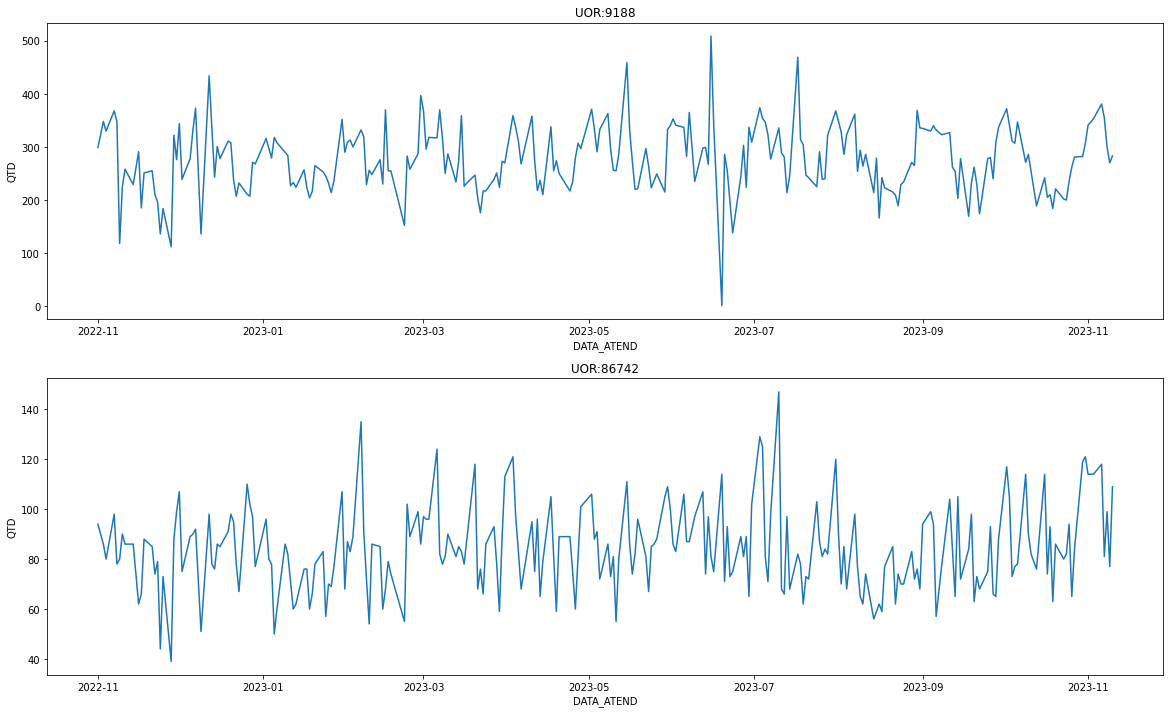

In [177]:
fig = plt.figure(figsize = (20,12))
fig.subplots_adjust(hspace=.2, wspace=0.2)
i = 1
for j,c in enumerate(atendimentos_uor.CD_UOR_SLCT.unique()): #['VL_FLX_VNCT','VL_VNCT','VL_FATM','IN_TRNS_TITD']):
#    print(i,j,c)
    data = qtd_clients_uor.query(f"CD_UOR_SLCT == {c}")
#    print(data.shape)
    ax = fig.add_subplot(2, 1, i)
    sns.lineplot(x='DATA_ATEND',y="QTD",data=data)
    plt.title(f"UOR:{c}")
    i += 1

In [112]:
print(2)

2


## ANALISE TEMPORAL QTD DE CLIENTES POR ESPAÇO DE ATENDIMENTO

In [178]:
qtd_cli_espaco_uor = ( atendimentos_uor.groupby(["CD_UOR_SLCT","CD_TIP_ESP_ATDT","DATA_ATEND"]).NR_SLCT_ATDT.count()
                   .reset_index().rename({"NR_SLCT_ATDT": "QTD"},axis=1)
                  )

qtd_cli_espaco_uor.head()

,CD_UOR_SLCT,CD_TIP_ESP_ATDT,DATA_ATEND,QTD
0,9188,1,2022-11-01,88
1,9188,1,2022-11-03,126
2,9188,1,2022-11-04,98
3,9188,1,2022-11-07,116
4,9188,1,2022-11-08,96


/usr/local/lib64/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib64/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


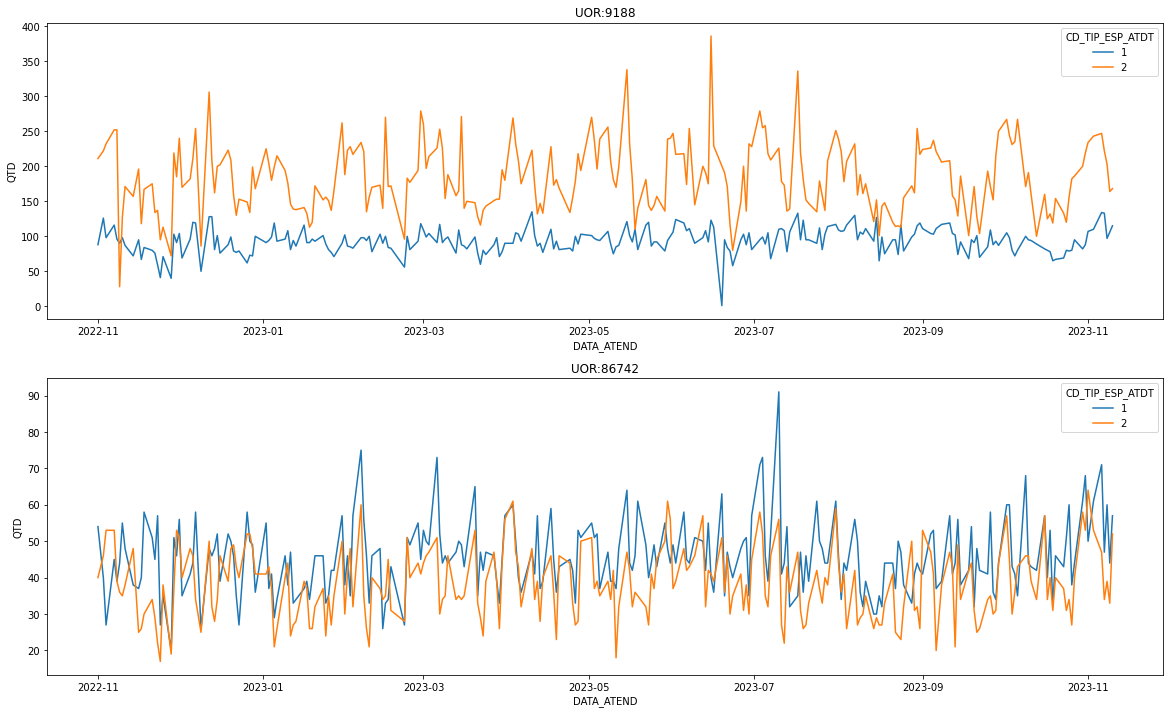

In [192]:
fig = plt.figure(figsize = (20,12))
fig.subplots_adjust(hspace=.2, wspace=0.2)
i = 1
for j,c in enumerate(atendimentos_uor.CD_UOR_SLCT.unique()): 
    data = qtd_cli_espaco_uor.query(f"CD_UOR_SLCT == {c}")
    data.CD_TIP_ESP_ATDT = data.CD_TIP_ESP_ATDT.astype(str)
    
    ax = fig.add_subplot(2, 1, i)
    sns.lineplot(x='DATA_ATEND',y="QTD",data=data, hue = 'CD_TIP_ESP_ATDT')
    plt.title(f"UOR:{c}")
    i += 1

## ANÁLISE QTD CLIENTES POR HORA ATENDIMENTO

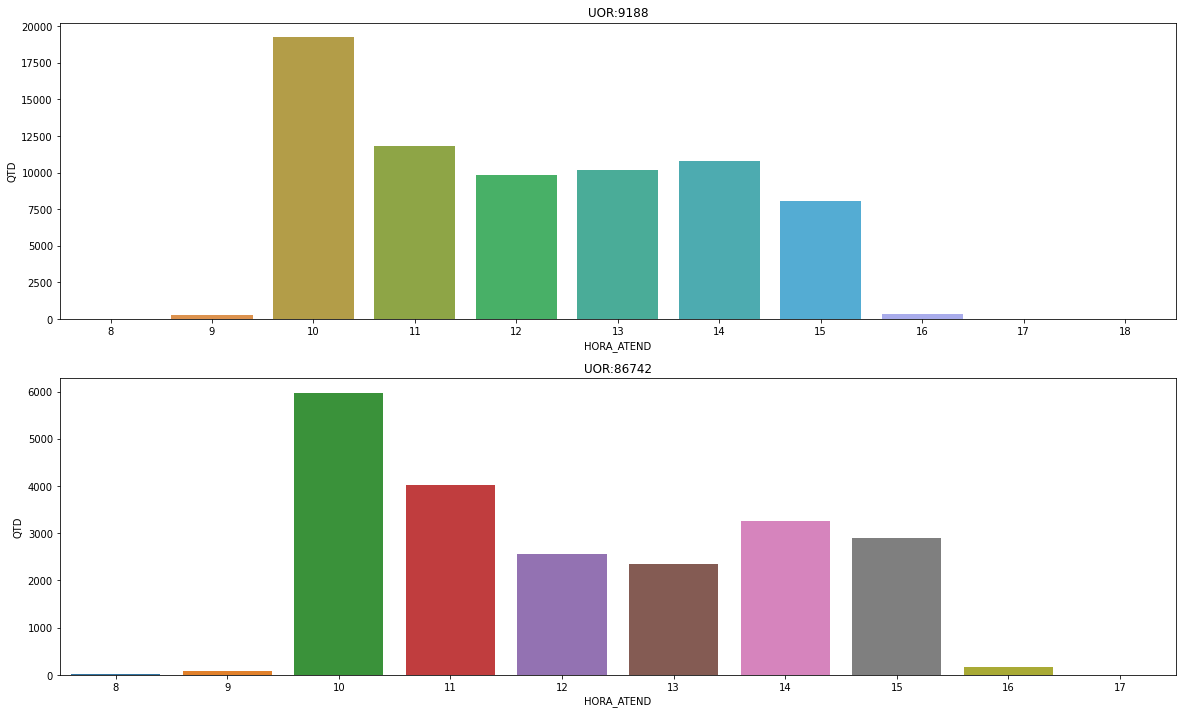

In [180]:
qtd_cli_hora_uor = ( atendimentos_uor.groupby(["CD_UOR_SLCT","HORA_ATEND"]).NR_SLCT_ATDT.count()
                   .reset_index().rename({"NR_SLCT_ATDT": "QTD"},axis=1)
                  )

fig = plt.figure(figsize = (20,12))
fig.subplots_adjust(hspace=.2, wspace=0.2)

i = 1
for j,c in enumerate(atendimentos_uor.CD_UOR_SLCT.unique()): 
    data = qtd_cli_hora_uor.query(f"CD_UOR_SLCT == {c}")
    ax = fig.add_subplot(2, 1, i)
    sns.barplot(x='HORA_ATEND',y="QTD",data=data)
    plt.title(f"UOR:{c}")
    i += 1

## ANÁLISE QTD CLIENTES POR HORA ATENDIMENTO E ESPAÇO DE ATENDIMENTO

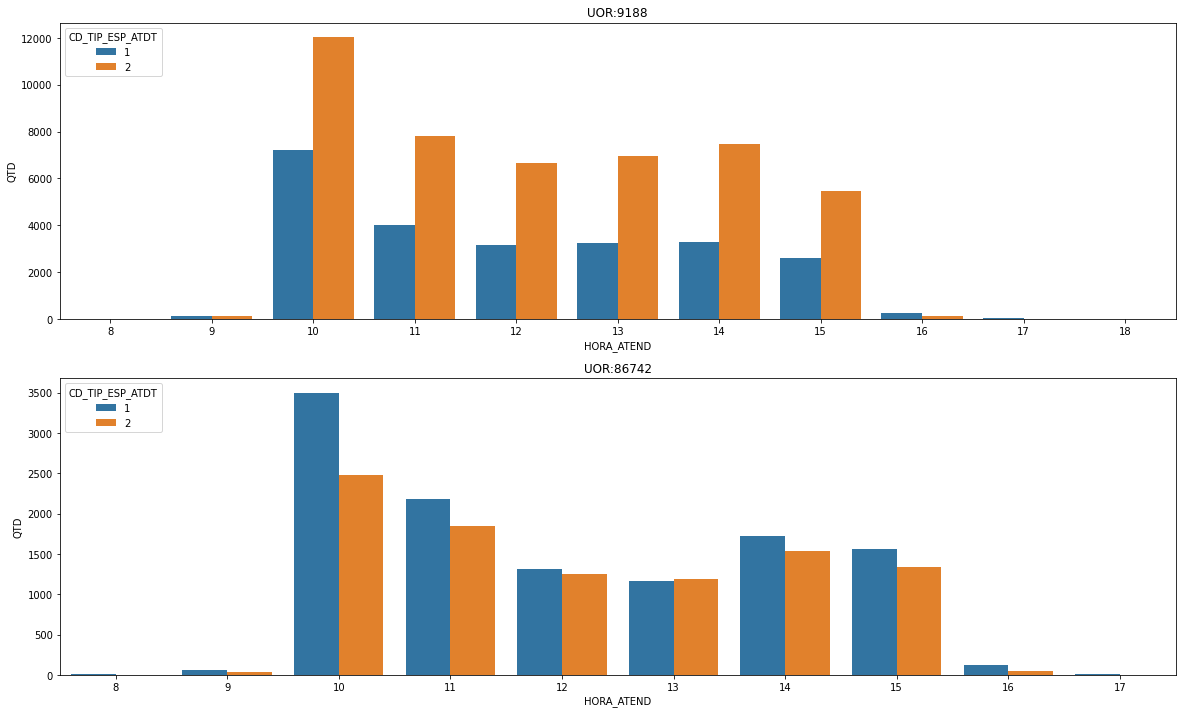

In [181]:
qtd_cli_hora_uor = ( atendimentos_uor.groupby(["CD_UOR_SLCT","HORA_ATEND","CD_TIP_ESP_ATDT"]).NR_SLCT_ATDT.count()
                   .reset_index().rename({"NR_SLCT_ATDT": "QTD"},axis=1)
                  )

fig = plt.figure(figsize = (20,12))
fig.subplots_adjust(hspace=.2, wspace=0.2)

i = 1
for j,c in enumerate(atendimentos_uor.CD_UOR_SLCT.unique()): 
    data = qtd_cli_hora_uor.query(f"CD_UOR_SLCT == {c}")
    ax = fig.add_subplot(2, 1, i)
    sns.barplot(x='HORA_ATEND',y="QTD",data=data,hue = 'CD_TIP_ESP_ATDT')
    plt.title(f"UOR:{c}")
    i += 1

## ANÁLISE DISTRIBUIÇÃO TEMPO DE ATENDIMENTO

In [122]:
atendimentos_uor.head()

,CD_UOR_SLCT,CD_TIP_ESP_ATDT,NR_SLCT_ATDT,NR_PTL_ATDT,DATA_ATEND,ANOMES_ATEND,HORA_ATEND,TEMPO_TOTAL_ATEND
0,33,2,1,1,2022-11-01,202211,10,4.62
1,33,2,2,2,2022-11-01,202211,10,0.57
2,33,2,3,3,2022-11-01,202211,10,5.63
3,33,1,4,4,2022-11-01,202211,10,21.73
4,33,2,5,5,2022-11-01,202211,10,2.00


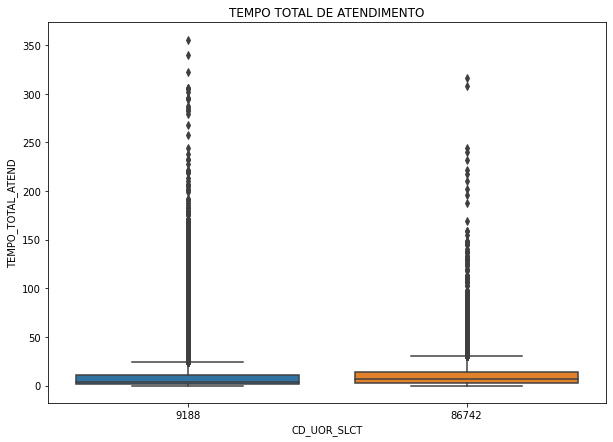

In [182]:
plt.figure(figsize = (10,7))
sns.boxplot(x='CD_UOR_SLCT',y="TEMPO_TOTAL_ATEND",data=atendimentos_uor)
plt.title(f"TEMPO TOTAL DE ATENDIMENTO")
plt.show()

## ANÁLISE DISTRIBUIÇÃO TEMPO DE ATENDIMENTO POR HORA DE ATENDIMENTO

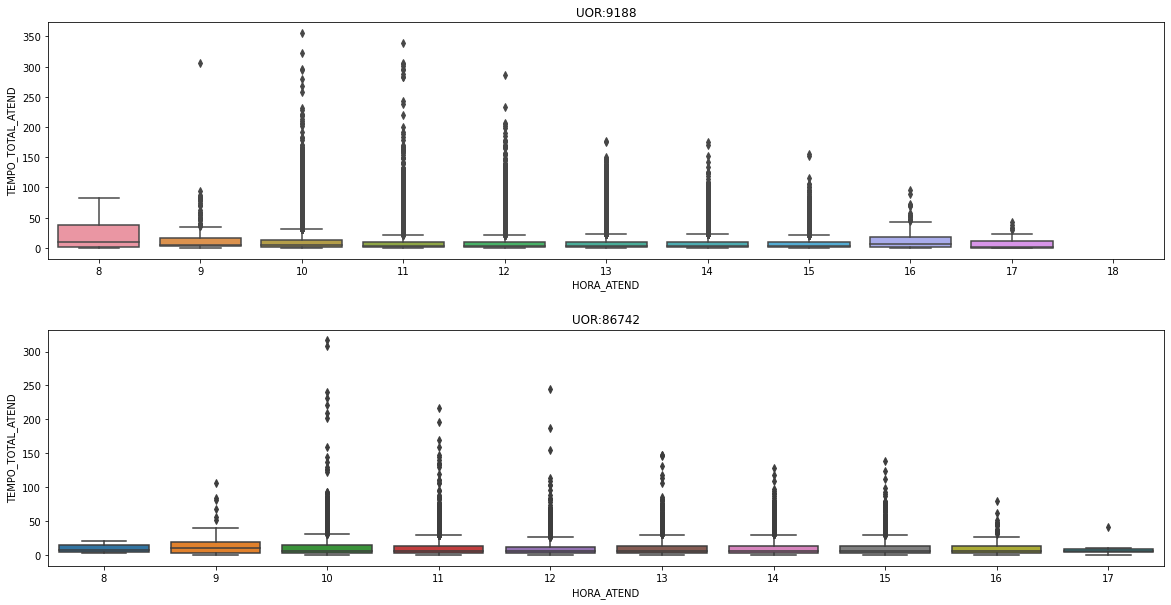

In [183]:
fig = plt.figure(figsize = (20,10))
fig.subplots_adjust(hspace=.3, wspace=0.2)
i = 1
for j,c in enumerate(atendimentos_uor.CD_UOR_SLCT.unique()): 
    data = atendimentos_uor.query(f"CD_UOR_SLCT == {c}")
    ax = fig.add_subplot(2, 1, i)
    sns.boxplot(y="TEMPO_TOTAL_ATEND",data=data,  x= 'HORA_ATEND')
    plt.title(f"UOR:{c}")
    i += 1

## ANALISE DISTIBUIÇÃO QTD DE CLIENTES POR DIA DA SEMANA 

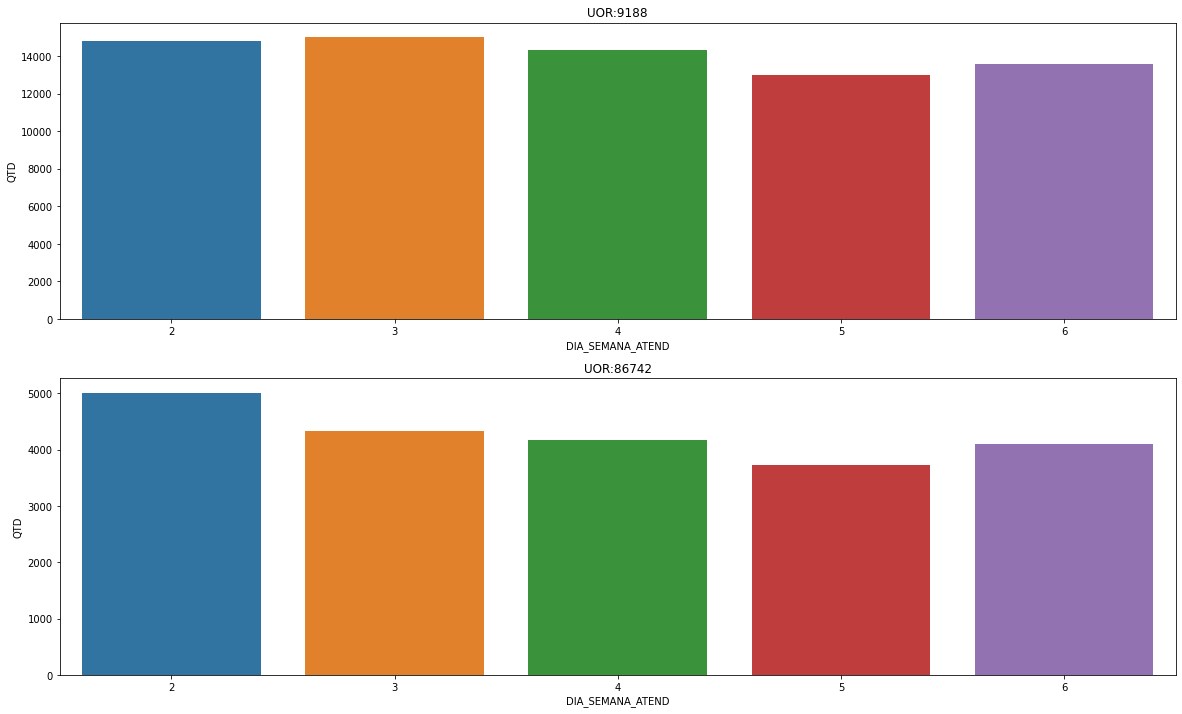

In [184]:
qtd_cli_dia_semana_uor = ( atendimentos_uor.groupby(["CD_UOR_SLCT","DIA_SEMANA_ATEND"]).NR_SLCT_ATDT.count()
                   .reset_index().rename({"NR_SLCT_ATDT": "QTD"},axis=1)
                  )

fig = plt.figure(figsize = (20,12))
fig.subplots_adjust(hspace=.2, wspace=0.2)

i = 1
for j,c in enumerate(atendimentos_uor.CD_UOR_SLCT.unique()): 
    data = qtd_cli_dia_semana_uor.query(f"CD_UOR_SLCT == {c}")
    ax = fig.add_subplot(2, 1, i)
    sns.barplot(x='DIA_SEMANA_ATEND',y="QTD",data=data)
    plt.title(f"UOR:{c}")
    i += 1

## ANALISE DISTIBUIÇÃO QTD DE CLIENTES POR DIA DA SEMANA POR ESPAÇO ATENDIMENTO

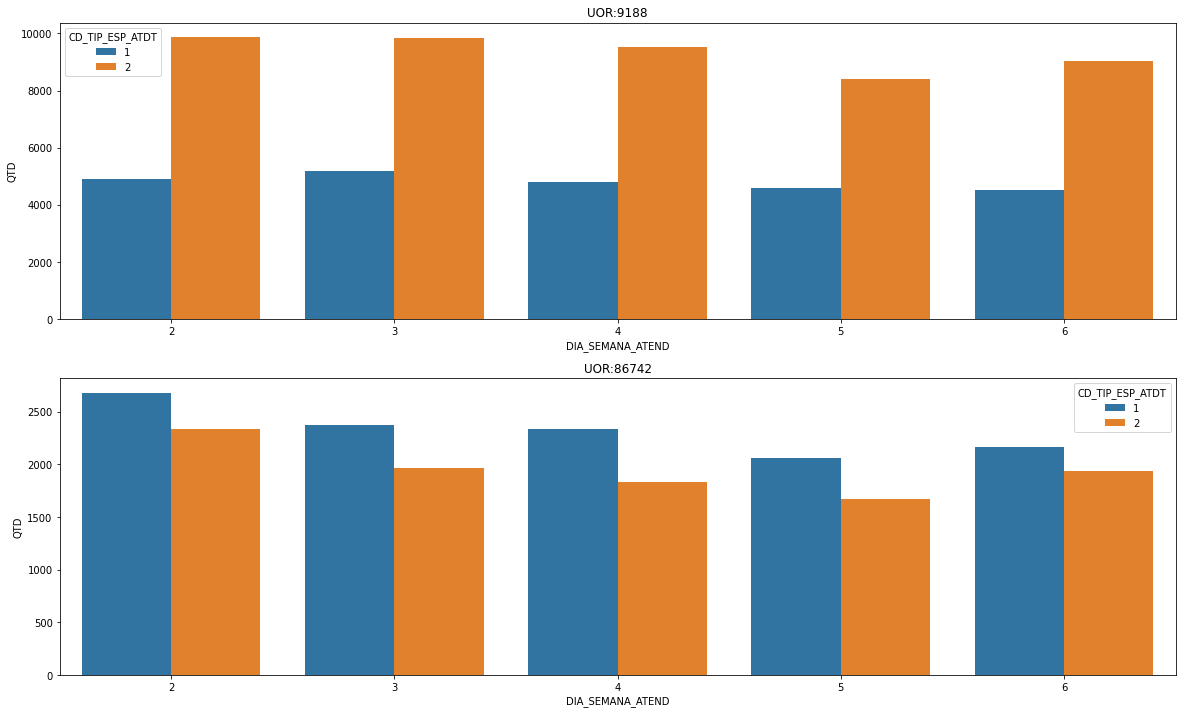

In [185]:
qtd_cli_dia_semana_espaco = ( atendimentos_uor.groupby(["CD_UOR_SLCT","DIA_SEMANA_ATEND","CD_TIP_ESP_ATDT"]).NR_SLCT_ATDT.count()
                   .reset_index().rename({"NR_SLCT_ATDT": "QTD"},axis=1)
                  )

fig = plt.figure(figsize = (20,12))
fig.subplots_adjust(hspace=.2, wspace=0.2)

i = 1
for j,c in enumerate(atendimentos_uor.CD_UOR_SLCT.unique()): 
    data = qtd_cli_dia_semana_espaco.query(f"CD_UOR_SLCT == {c}")
    ax = fig.add_subplot(2, 1, i)
    sns.barplot(x='DIA_SEMANA_ATEND',y="QTD",data=data, hue = 'CD_TIP_ESP_ATDT')
    plt.title(f"UOR:{c}")
    i += 1

## ANALISE DISTIBUIÇÃO QTD DE CLIENTES POR DIA DO MES 

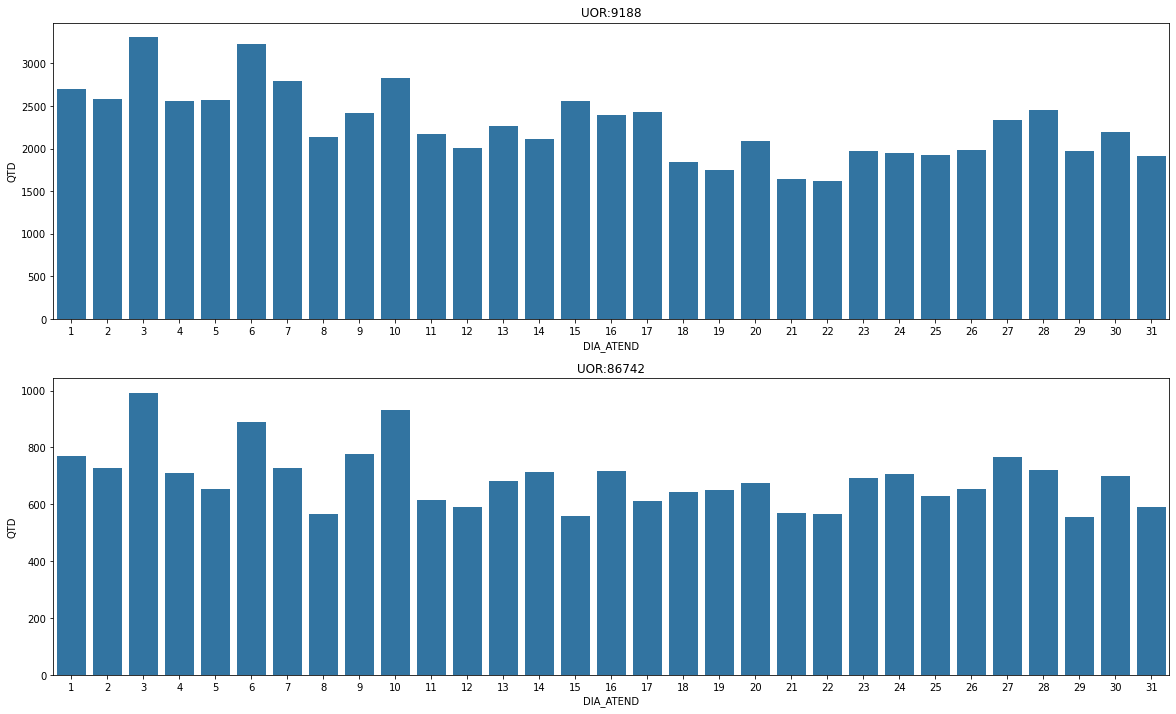

In [189]:
qtd_cli_dia_mes = ( atendimentos_uor.groupby(["CD_UOR_SLCT","DIA_ATEND"]).NR_SLCT_ATDT.count()
                   .reset_index().rename({"NR_SLCT_ATDT": "QTD"},axis=1)
                  )

fig = plt.figure(figsize = (20,12))
fig.subplots_adjust(hspace=.2, wspace=0.2)

i = 1
for j,c in enumerate(atendimentos_uor.CD_UOR_SLCT.unique()): 
    data = qtd_cli_dia_mes.query(f"CD_UOR_SLCT == {c}")
    ax = fig.add_subplot(2, 1, i)
    sns.barplot(x='DIA_ATEND',y="QTD",data=data, color = '#1f77b4')
    plt.title(f"UOR:{c}")
    i += 1

## ANALISE DISTIBUIÇÃO QTD DE CLIENTES POR DIA POR ESPAÇO ATENDIMENTO

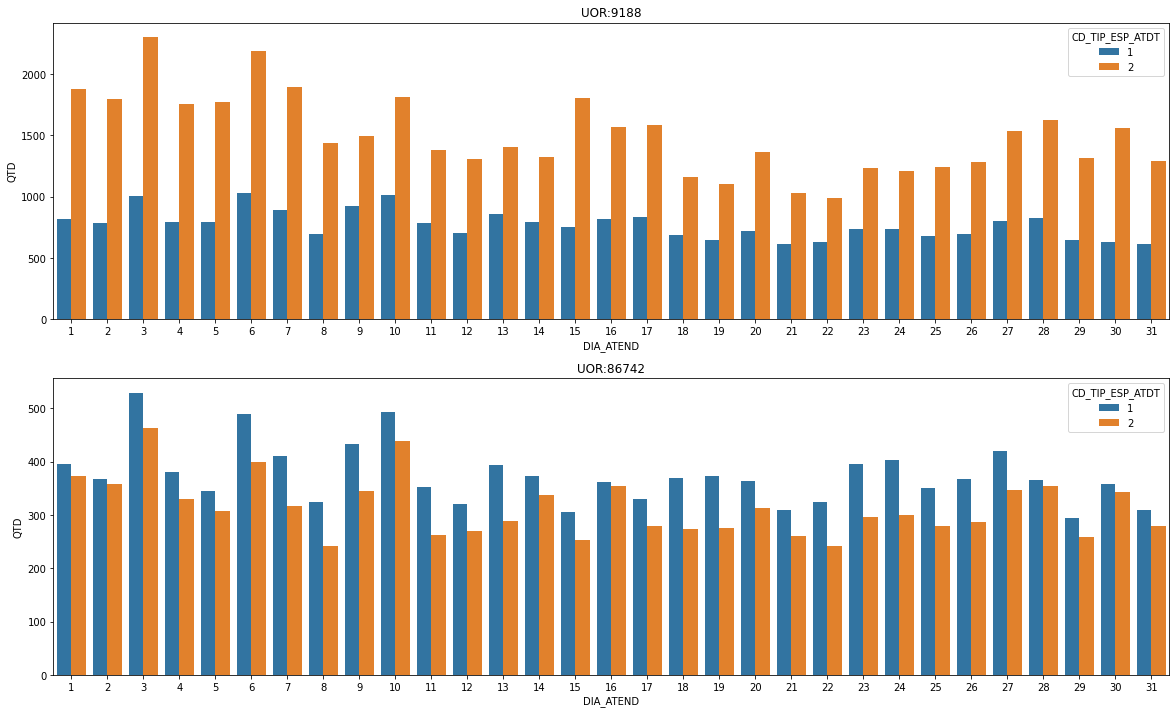

In [188]:
qtd_cli_dia_mes_espaco = ( atendimentos_uor.groupby(["CD_UOR_SLCT","DIA_ATEND","CD_TIP_ESP_ATDT"]).NR_SLCT_ATDT.count()
                   .reset_index().rename({"NR_SLCT_ATDT": "QTD"},axis=1)
                  )

fig = plt.figure(figsize = (20,12))
fig.subplots_adjust(hspace=.2, wspace=0.2)

i = 1
for j,c in enumerate(atendimentos_uor.CD_UOR_SLCT.unique()): 
    data = qtd_cli_dia_mes_espaco.query(f"CD_UOR_SLCT == {c}")
    ax = fig.add_subplot(2, 1, i)
    sns.barplot(x='DIA_ATEND',y="QTD",data=data, hue = 'CD_TIP_ESP_ATDT')
    plt.title(f"UOR:{c}")
    i += 1

## ANÁLISES DE RELAÇÃO E CORRELAÇÃO

In [194]:
print(atendimentos_uor.columns)
atendimentos_uor.head()

Index(['CD_UOR_SLCT', 'CD_TIP_ESP_ATDT', 'NR_SLCT_ATDT', 'NR_PTL_ATDT',
       'DATA_ATEND', 'DIA_ATEND', 'DIA_SEMANA_ATEND', 'ANOMES_ATEND',
       'HORA_ATEND', 'TEMPO_TOTAL_ATEND'],
      dtype='object')


,CD_UOR_SLCT,CD_TIP_ESP_ATDT,NR_SLCT_ATDT,NR_PTL_ATDT,DATA_ATEND,DIA_ATEND,DIA_SEMANA_ATEND,ANOMES_ATEND,HORA_ATEND,TEMPO_TOTAL_ATEND
0,9188,1,1,1,2022-11-01,1,3,202211,10,28.32
1,86742,2,1,1,2022-11-01,1,3,202211,10,0.30
2,86742,2,2,2,2022-11-01,1,3,202211,10,0.38
3,86742,1,3,3,2022-11-01,1,3,202211,10,22.27
4,9188,2,2,2,2022-11-01,1,3,202211,10,1.90


In [224]:
group_qtd_atend = ( atendimentos_uor.groupby(['CD_UOR_SLCT','CD_TIP_ESP_ATDT','DIA_ATEND','DIA_SEMANA_ATEND','HORA_ATEND']).NR_SLCT_ATDT.count()
                     .reset_index().rename({"NR_SLCT_ATDT": "QTD"},axis=1)
                    )
group_qtd_atend.head()

,CD_UOR_SLCT,CD_TIP_ESP_ATDT,DIA_ATEND,DIA_SEMANA_ATEND,HORA_ATEND,QTD
0,9188,1,1,3,10,66
1,9188,1,1,3,11,28
2,9188,1,1,3,12,23
3,9188,1,1,3,13,27
4,9188,1,1,3,14,25


In [231]:
group_tempo_atend = ( atendimentos_uor.groupby(['CD_UOR_SLCT','CD_TIP_ESP_ATDT','DIA_ATEND','DIA_SEMANA_ATEND','HORA_ATEND'])
                         .agg({'TEMPO_TOTAL_ATEND' : ['min','mean','median','max']})
                         .reset_index()
                        )
#group_tempo_atend.columns = ['_'.join(col).upper() if type(col) is tuple else col for col in group_tempo_atend.columns.values]
group_tempo_atend.columns = ['CD_UOR_SLCT', 'CD_TIP_ESP_ATDT', 'DIA_ATEND', 'DIA_SEMANA_ATEND',
                             'HORA_ATEND', 'TEMPO_TOTAL_ATEND_MIN', 'TEMPO_TOTAL_ATEND_MEAN',
                             'TEMPO_TOTAL_ATEND_MEDIAN', 'TEMPO_TOTAL_ATEND_MAX']
group_tempo_atend.head()

,CD_UOR_SLCT,CD_TIP_ESP_ATDT,DIA_ATEND,DIA_SEMANA_ATEND,HORA_ATEND,TEMPO_TOTAL_ATEND_MIN,TEMPO_TOTAL_ATEND_MEAN,TEMPO_TOTAL_ATEND_MEDIAN,TEMPO_TOTAL_ATEND_MAX
0,9188,1,1,3,10,0.43,29.584242,25.065,89.07
1,9188,1,1,3,11,0.33,21.150714,11.675,78.78
2,9188,1,1,3,12,0.35,24.668261,18.870,74.43
3,9188,1,1,3,13,0.50,29.858148,26.350,113.92
4,9188,1,1,3,14,0.32,28.763600,21.380,86.33


In [237]:
group_qtd_atend.CD_UOR_SLCT.unique()

array([ 9188, 86742])

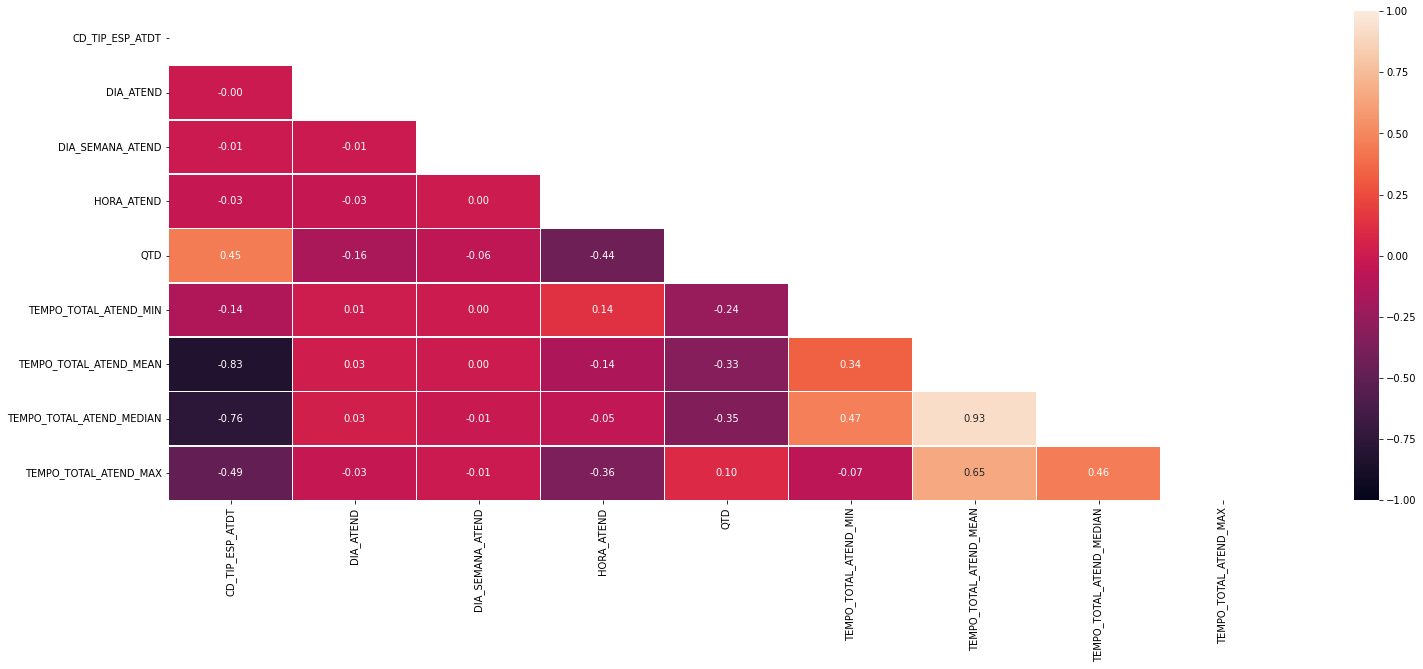

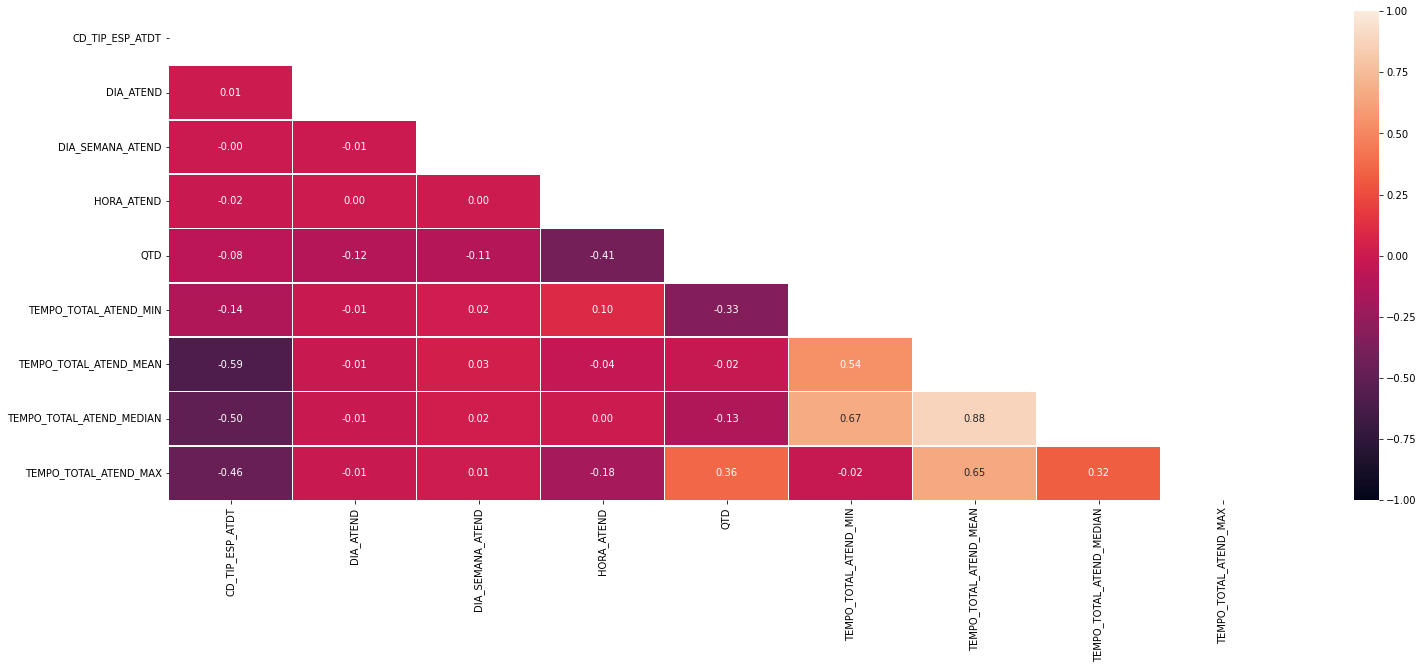

In [244]:
import numpy as np
#fig, axs = plt.subplots(2,1, figsize=(25, 9), sharey=False)
#fig.subplots_adjust(hspace=.5, wspace=1.35)


for uor in group_qtd_atend.CD_UOR_SLCT.unique():
    plt.figure(figsize=(25, 9))
    dados = group_qtd_atend.merge(group_tempo_atend)
    dados = dados.query(f"CD_UOR_SLCT == {uor}").drop(["CD_UOR_SLCT"],axis=1)
    corr  = dados.corr()

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    #sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, annot=True, square=False, fmt=".2f",linewidths=.5,ax = axs)
    sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, annot=True, square=False, fmt=".2f",linewidths=.5)

    #axs.set_title(f"pearson: {uor}")
    #axs.set_xticklabels(axs.get_xticklabels(), rotation = 45,ha="right")

    plt.show()